<h1>Khai báo thư viện</h1>
- Khai báo các thư viện sử dụng</br>
- Define các biến toàn cục

In [ ]:
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from keras.models import load_model

import numpy as np
import timeit

import matplotlib.pyplot as plt
from matplotlib.image import imread

from shutil import copyfile
from shutil import rmtree

import random

length = 227
width = 227
height = 3
epoch = 55
batchSize = 32
learning_rate = 1e-4
data_dir = './data'
check_point_path='./checkpoint.h5'

<h1>Tạo cây thư mục</h1>
Tạo <b>cây thư mục</b> có cấu trúc như bên dưới:
<pre>
./data
├── train
│   ├── cats
│   └── dogs
├── val
│   ├── cats
│   └── dogs
└── test
    ├── cats
    └── dogs</pre>

In [ ]:
def train_validate_test_split(data, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(np.arange(len(data)))
    m = len(data)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end

    train = np.array(data)[:train_end].copy()
    validate = np.array(data)[train_end:validate_end].copy()
    test = np.array(data)[validate_end:-2].copy()

    return train, validate, test


if os.path.isdir(data_dir):
    print('Deleting data directory...',end='')
    rmtree(data_dir)
    print('Done!',end='\n')

os.makedirs(data_dir, exist_ok=True)

data_dir = data_dir + '/'

subdirs = ['train/', 'val/', 'test/']

print('Create subdirectory.......',end='')
for subdir in subdirs:
    # Create label subdirectories
    labeldirs = ['dogs/', 'cats/']

    for labldir in labeldirs:
        newdir = data_dir + subdir + labldir
        os.makedirs(newdir, exist_ok=True)

print('Done!',end='\n')

# Copy dataset into folders
dog_files = []
cat_files = []

# Copy training dataset images into subdirectories
src_directory = '../input/dogs-vs-cats/dogs-vs-cats/train/train'

for file in os.listdir(src_directory):
    if file.startswith('cat'):
        cat_files.append(file)
    elif file.startswith('dog'):
        dog_files.append(file)

print('Cat:', len(cat_files))
print('Dog:', len(dog_files))

train_cats, val_cats, test_cats = train_validate_test_split(
    cat_files, seed=42, train_percent=.6, validate_percent=.2)
train_dogs, val_dogs, test_dogs = train_validate_test_split(
    dog_files, seed=42, train_percent=.6, validate_percent=.2)

print('Classify directory........',end ='')
list(map(lambda file: copyfile(src_directory + '/' + file, data_dir + 'train/cats/' + file), train_cats))
list(map(lambda file: copyfile(src_directory + '/' + file, data_dir + 'train/dogs/' + file), train_dogs))
list(map(lambda file: copyfile(src_directory + '/' + file, data_dir + 'val/cats/' + file), val_cats))
list(map(lambda file: copyfile(src_directory + '/' + file, data_dir + 'val/dogs/' + file), val_dogs))
list(map(lambda file: copyfile(src_directory + '/' + file, data_dir + 'test/cats/' + file), test_cats))
list(map(lambda file: copyfile(src_directory + '/' + file, data_dir + 'test/dogs/' + file), test_dogs))

print("Done!",end='\n')

<h1>Data Augment</h1>
Sử dụng <b>ImageDataGenerator</b> để tạo thêm các ảnh mới từ tập ảnh gốc bằng cách: <i>lật ngang, lật dọc, kéo méo ảnh, phóng to, thu nhỏ ảnh, tăng giảm sáng, tương phản, thêm noise…</i> </br>
&rarr; Nhằm đa dạng góc nhìn về các bức ảnh để train model

In [ ]:
# Generating images for the Test set
print('Generating images.........', end='')
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Creating training set
train_it = train_datagen.flow_from_directory(data_dir +'/train/',
                                             class_mode='binary', batch_size=batchSize, target_size=(length, width))
val_it = val_datagen.flow_from_directory(data_dir +'/val/',
                                         class_mode='binary', batch_size=batchSize, target_size=(length, width))

# Creating the Test set
test_it = test_datagen.flow_from_directory(data_dir +'/test/',
                                           class_mode='binary', batch_size=batchSize, target_size=(length, width))

print('Done!',end='\n')

<h1>Hàm <b>Define CNN model</b></h1>
Dùng mô hình <b>AlexNet</b> </br>
<a href='https://www.kaggle.com/blurredmachine/alexnet-architecture-a-complete-guide'>* Reference: <b>AlexNet Architecture</b> </a></br>
<a href='https://vitorgabo.medium.com/cats-and-dogs-classification-using-alexnet-5fc52b1cc1a6'>* Reference: <b>Cats and Dogs classification using AlexNet</b> </a>

In [ ]:
def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate)

def defineModel():
    print('Defining model..........',end='')
    # initializing the CNN
    model = keras.Sequential()

    model.add(Conv2D(64, (3, 3), activation="relu", padding="same",
                     kernel_initializer='he_uniform', name='conv1', input_shape=(length,width,height)))

    model.add(Conv2D(96, (11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= (length,width,height),
                        kernel_initializer= 'he_normal', name='conv2'))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None, name='maxpool1'))

    model.add(Conv2D(256, (5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal', name='conv3'))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None, name='maxpool2')) 

    model.add(Conv2D(384, (3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal', name='conv4'))

    model.add(Conv2D(384, (3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal', name='conv5'))

    model.add(Conv2D(256, (3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal', name='conv6'))

    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None, name='maxpool3'))

    model.add(Flatten())
    model.add(Dense(4096, activation= 'relu'))
    model.add(Dense(4096, activation= 'relu'))
    model.add(Dense(1000, activation= 'relu'))
    model.add(Dense(1, activation= 'sigmoid'))

    # compile model
    model.compile(optimizer=optimizer_init_fn(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])  

    print('Done!',end='\n')
    return model

<h1>Load model</h1>
- Nạp model đang được train dở từ trước</br>
- File model được train dở: <b>./checkpoint.h5</b>


In [ ]:
# kiểm tra nếu model đã train dở từ trước thì tiến hành nạp và chạy
if os.path.exists(check_point_path) == True:
    print('Model loading....',end='')
    # nạp model đã chạy dở từ lần trước
    model = load_model(check_point_path)
    print('Done!',end='\n')
else:
    print('Model had not trained before')

<h1>Callback</h1>
<a href='https://miai.vn/2020/09/05/keras-callbacks-tro-thu-dac-luc-khi-train-models/'>* Reference: <b>Callback</b></a></br>
Lưu lại các trạng thái và thông số của model trong quá trình training vào file <b>checkpoint.hdf5</b> </br>
- Stop quá trình training khi model đạt được một kết quả accuracy/ loss nhất định nào đó</br>
- Lưu lại model sau mỗi epoch</br>



In [ ]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
checkPoint = tf.keras.callbacks.ModelCheckpoint(check_point_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

callback = [earlyStopping, checkPoint]

<h1>Hàm <b>Train model</b></h1>


In [ ]:
def trainModel(model,train_it, val_it,epoch):
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                                  validation_data=val_it, validation_steps=len(val_it), epochs=epoch, verbose=1,
                                  callbacks=[callback])

    return history

<h1>Hàm <b>Lưu model đã train</b></h1>
<a href='https://tek4.vn/cach-luu-va-load-lai-mot-mo-hinh-hoc-sau-keras-co-ban'>* Reference: <b>Save and load model</b></a>

In [ ]:
def saveModel(file_name):
    print('Saving model.......',end='')
    model.save('final_model.h5')
    print('Done!', end='\n')

<h1>Hàm <b>Đánh giá mô hình</b></h1>
- Sau khi train xong, tiến hành đánh giá qua tập data <b>test_it</b> và in ra độ chính xác của phân loại </br>
- Địa chỉ của tập test_it: <b>./data/test</b>


In [ ]:
def evaluateModel(test_it):
    # evaluate model
    print('Evaluate model.......',end='')
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> accuracy: %.3f' % (acc * 100.0), end='\n')    

<h1>Hàm <b>Visualize Training</b></h1>
- Vẽ đồ thị <b>Visualize</b> quá trình training </br>
- Tóm tắt mô hình 

In [ ]:
def summarize_diagnostics(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

<h1>Hàm <b>Test dự đoán kết quả</b></h1>
- Tiến hành dự đoán kết quả từ model đã train </br>
- Model đạt độ chính xác: <b>93.375%</b>

In [ ]:
def predict(model, link):
    image = cv2.imread(link)
    image = cv2.resize(image, (length,width))
    preds = model.predict(np.expand_dims(image, axis=0))[0]
    plt.imshow(image)
    plt.show()
    if preds==0:
        print("Predicted:Cat")
    else:
        print("Predicted: Dog")  
        
def test(model,test_dir, numtest):
    print('Testing.........')
    test_cat = test_dir + '/cats'
    test_dog = test_dir + '/dogs'
    for i in range(numtest):
        # test cat
        filename = random.choice(os.listdir(test_cat))
        predict(model, test_cat + '/' + filename) 
        
        # test dog
        filename = random.choice(os.listdir(test_dog))
        predict(model, test_dog + '/' + filename) 

<h1>(Main) <b>Test model đã train từ trước</b></h1>
- Các ảnh test được đặt trong mục <b>./data/test</b></br>
- Hàm này lấy ngẫu nhiên <b>numtest</b> chó, mèo ra test

In [ ]:
print('Model loading.......',end='')
model = load_model('../input/dogs-vs-cats/final_model.h5')
print('Done!',end='\n')

evaluateModel(test_it)

model.summary()

test(model,'./data/test',3)

<h1>(Main) <b>Train và chạy lại từ đầu</b></h1>

In [ ]:
model = defineModel()
# kiểm tra nếu model đã train dở từ trước thì tiến hành nạp và chạy
if os.path.exists(check_point_path) == True:
    print('Model loading......Done!')
    # nạp model đã chạy dở từ lần trước
    model = load_model(check_point_path)
else:
    print('Model had not trained before')
    
    
history = trainModel(model,train_it, val_it, epoch)

saveModel('final_model.h5')

evaluateModel(test_it)

summarize_diagnostics(history)

model.summary()

test(model,'./data/test',3)

<h1>Kết quả tóm tắt lịch sử train</h1>
Đây là lịch sử sau khi train 55 epoch


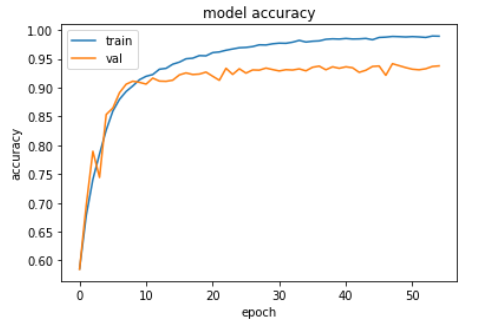
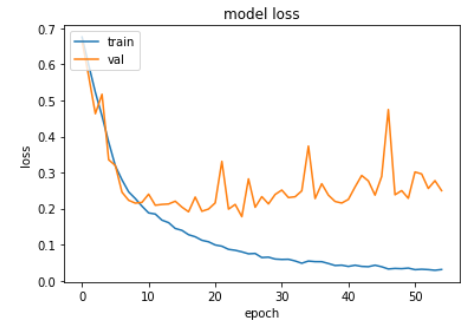